Modelo SVM para predecir deserción real (académica + social/territorial)

Escuela de Artes Plásticas - Termas de Río Hondo

In [ ]:
# 1. IMPORTACIÓN DE LIBRERÍAS

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, roc_auc_score
)
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


In [ ]:
# 2. CARGA Y PREPARACIÓN INICIAL DEL DATASET

df = pd.read_csv("/content/Artes_Plasticas_bbdd.csv")

print("Dataset cargado correctamente.\n")
print(df.head(), "\n")
print("Dimensiones iniciales:", df.shape)

# Limpiar nombres de columnas
df.columns = df.columns.str.strip()

print("Columnas del dataset:")
print(df.columns)


Dataset cargado correctamente.

        Marca temporal        Apellido y Nombre  Edad      Sexo  Grado  \
0  12/11/2025 11:00:56   Moreira Martina Jazmin    13   Femenino    1°   
1  12/11/2025 11:01:28              Suárez Ana     14   Femenino    1°   
2  12/11/2025 11:01:40  Saavedra Daniel Claudio    14  Masculino    1°   
3  12/11/2025 11:02:01         Rojas francisco     15  Masculino    1°   
4  12/11/2025 11:02:06  Saavedra Daniel Claudio    14  Masculino    1°   

  Actividad Extracurricular  Conectividad ¿Asistís a los talleres ?  \
0                         Si           Si                        Si   
1                         No           Si                        Si   
2                         Si           Si                        Si   
3                         No           Si                        Si   
4                         Si           Si                        Si   

  Distancia a la escuela ¿Trabajas? Situación Familiar Nivel socio económico  \
0               

In [ ]:
# Asegurar tipos numéricos en Asistencia e Inasistencia

df["Asistencia %"] = pd.to_numeric(df["Asistencia %"], errors="coerce")
df["Inasistencia %"] = pd.to_numeric(df["Inasistencia %"], errors="coerce")

# Normalizar textos importantes (sacamos espacios y unificamos)

df["Promedio"] = df["Promedio"].astype(str).str.strip().str.capitalize()

df["Situación Familiar"] = df["Situación Familiar"].astype(str).str.strip()
df["Distancia a la escuela"] = df["Distancia a la escuela"].astype(str).str.strip()

# Otras columnas sociales
if "Nivel socio económico" in df.columns:
    df["Nivel socio económico"] = df["Nivel socio económico"].astype(str).str.strip().str.capitalize()

if "Conectividad" in df.columns:
    df["Conectividad"] = df["Conectividad"].astype(str).str.strip().str.capitalize()

if "Actividad Extracurricular" in df.columns:
    df["Actividad Extracurricular"] = df["Actividad Extracurricular"].astype(str).str.strip().str.capitalize()

if "¿Trabajas?" in df.columns:
    df["¿Trabajas?"] = df["¿Trabajas?"].astype(str).str.strip().str.capitalize()

if "Sexo " in df.columns and "Sexo" not in df.columns:
    df = df.rename(columns={"Sexo ": "Sexo"})
if "Sexo" in df.columns:
    df["Sexo"] = df["Sexo"].astype(str).str.strip().str.capitalize()


In [ ]:
# Eliminar filas con datos faltantes en columnas clave

cols_clave = [
    "Asistencia %", "Inasistencia %", "Promedio",
    "Situación Familiar", "Distancia a la escuela"
]
df = df.dropna(subset=cols_clave)

print("\nDimensiones después de limpiar nulos en columnas clave:", df.shape)


Dimensiones después de limpiar nulos en columnas clave: (151, 16)


In [ ]:
# 3. CREACIÓN DE LA VARIABLE OBJETIVO: DESERCIÓN REAL

# --- CRITERIOS ACADÉMICOS ---
acad_asistencia = df["Asistencia %"] < 60
acad_inasistencia = df["Inasistencia %"] > 40
acad_promedio = df["Promedio"] == "Regular"

# --- CRITERIOS SOCIALES / TERRITORIALES ---
# Normalizamos a minúsculas para comparar categorías
sit_fam_lower = df["Situación Familiar"].str.lower()
dist_lower = df["Distancia a la escuela"].str.lower()

familias_vulnerables = [
    "madre sola",
    "padre solo",
    "otro familiar a cargo"
    # "ambos padres" se considera más protectora
]
social_sit_fam = sit_fam_lower.isin(familias_vulnerables)

# Distancia: Lejos = riesgo, Medio/Cerca = menor riesgo
social_distancia_lejos = dist_lower == "lejos"

# Condición social global: vulnerable por familia o por distancia
social_riesgo = (social_sit_fam | social_distancia_lejos)

# --- DESERCIÓN REAL: ACADÉMICA + SOCIAL/ TERRITORIAL ---
df["Desercion_real"] = (
    acad_asistencia & acad_inasistencia & acad_promedio & social_riesgo
).astype(int)

print("\nDistribución de DESERCIÓN REAL (0 = continúa, 1 = deserta):")
print(df["Desercion_real"].value_counts())

print("\nMuestra de casos con variables clave y deserción:")
print(df[[
    "Asistencia %", "Inasistencia %", "Promedio",
    "Situación Familiar", "Distancia a la escuela",
    "Desercion_real"
]].head(20))


Distribución de DESERCIÓN REAL (0 = continúa, 1 = deserta):
Desercion_real
0    143
1      8
Name: count, dtype: int64

Muestra de casos con variables clave y deserción:
    Asistencia %  Inasistencia %       Promedio Situación Familiar  \
1           95.0             5.0  Sobresaliente   Con ambos padres   
2           87.0            13.0  Sobresaliente   Con ambos padres   
3           90.0            10.0          Bueno   Con ambos padres   
4          100.0           100.0  Sobresaliente   Con ambos padres   
5           80.0            20.0          Bueno         Madre Sola   
6           95.0             5.0          Bueno         Madre Sola   
7           88.0            12.0          Bueno   Con ambos padres   
8           81.0            19.0          Bueno   Con ambos padres   
9           90.0            10.0  Sobresaliente   Con ambos padres   
10          87.0            13.0          Bueno   Con ambos padres   
11          98.0             2.0  Sobresaliente   Con ambos

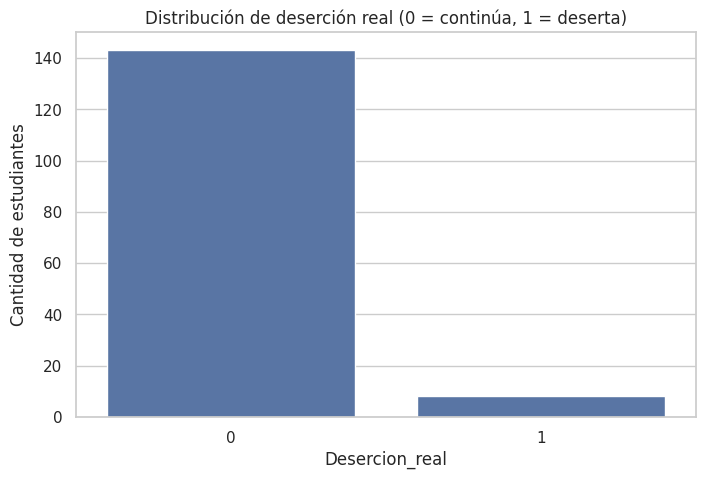

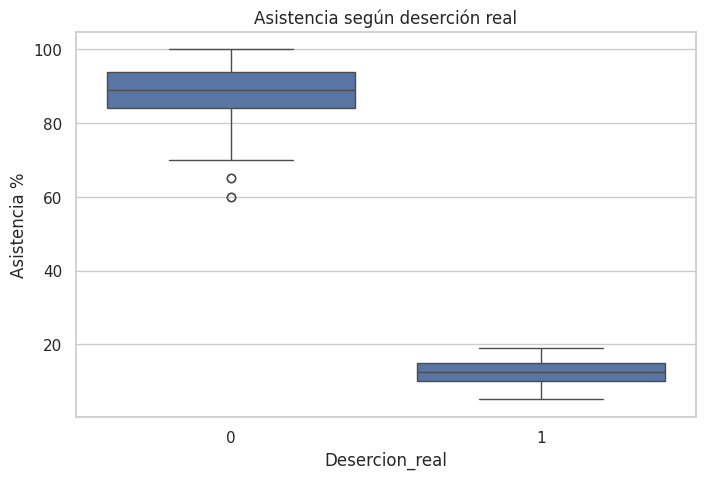

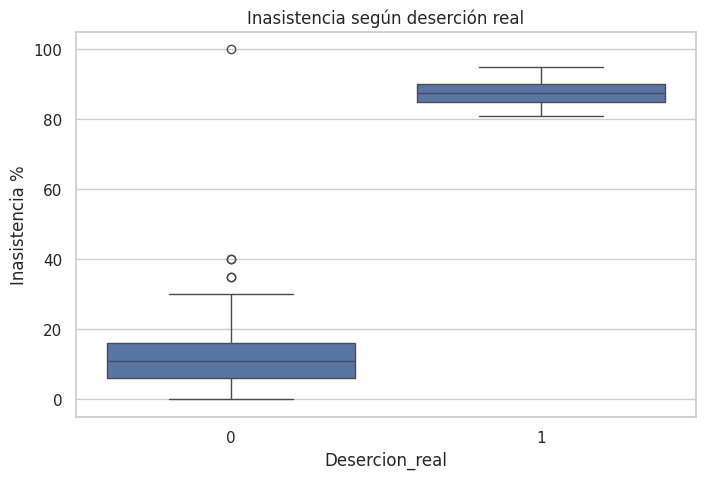

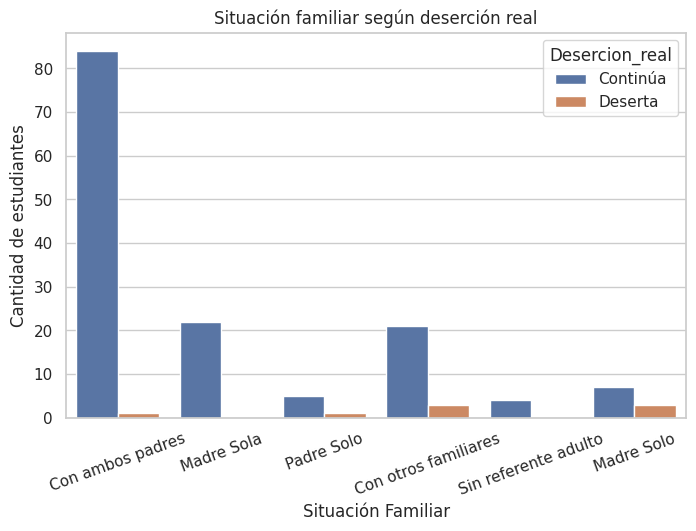

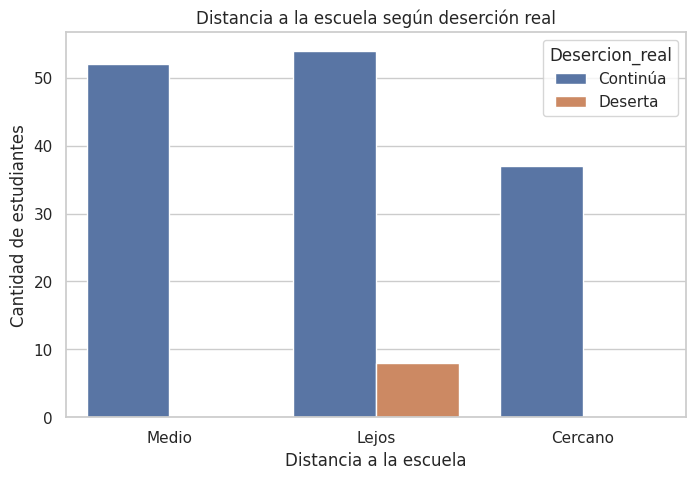

In [ ]:
# 4. EDA: VISUALIZACIONES EXPLICATIVAS

# a) Distribución de la deserción real
sns.countplot(x="Desercion_real", data=df)
plt.title("Distribución de deserción real (0 = continúa, 1 = deserta)")
plt.xlabel("Desercion_real")
plt.ylabel("Cantidad de estudiantes")
plt.show()

# b) Asistencia según deserción
sns.boxplot(x="Desercion_real", y="Asistencia %", data=df)
plt.title("Asistencia según deserción real")
plt.xlabel("Desercion_real")
plt.ylabel("Asistencia %")
plt.show()

# c) Inasistencia según deserción
sns.boxplot(x="Desercion_real", y="Inasistencia %", data=df)
plt.title("Inasistencia según deserción real")
plt.xlabel("Desercion_real")
plt.ylabel("Inasistencia %")
plt.show()

# d) Situación familiar versus deserción
sns.countplot(x="Situación Familiar", hue="Desercion_real", data=df)
plt.title("Situación familiar según deserción real")
plt.xlabel("Situación Familiar")
plt.ylabel("Cantidad de estudiantes")
plt.xticks(rotation=20)
plt.legend(title="Desercion_real", labels=["Continúa", "Deserta"])
plt.show()

# e) Distancia a la escuela versus deserción
sns.countplot(x="Distancia a la escuela", hue="Desercion_real", data=df)
plt.title("Distancia a la escuela según deserción real")
plt.xlabel("Distancia a la escuela")
plt.ylabel("Cantidad de estudiantes")
plt.legend(title="Desercion_real", labels=["Continúa", "Deserta"])
plt.show()


In [ ]:
columnas_excluir = [
    "Marca temporal",
    "Apellido y Nombre",
    "Asistencia %",
    "Inasistencia %",
    "Promedio",
    "Situación Familiar",
    "Distancia a la escuela",
    "," # Add the comma column to be excluded
]

df_modelo = df.drop(columns=columnas_excluir, errors="ignore")

print("Columnas en df_modelo:")
print(df_modelo.columns)

# Separar X (features) e y (target)
X = df_modelo.drop("Desercion_real", axis=1)
y = df_modelo["Desercion_real"]

# One-hot encoding para manejar variables categóricas con SVM
X = pd.get_dummies(X, drop_first=True)

print("\nDimensiones finales de X:", X.shape)
print("Primeras columnas de X:")
print(X.columns[:15])

Columnas en df_modelo:
Index(['Edad', 'Sexo', 'Grado', 'Actividad Extracurricular', 'Conectividad',
       '¿Asistís a los talleres ?', '¿Trabajas?', 'Nivel socio económico',
       'Desercion_real'],
      dtype='object')

Dimensiones finales de X: (151, 12)
Primeras columnas de X:
Index(['Edad', 'Sexo_Masculino', 'Grado_2°', 'Grado_3°', 'Grado_4°',
       'Grado_5°', 'Actividad Extracurricular_Si', 'Conectividad_Si',
       '¿Asistís a los talleres ?_Si', '¿Trabajas?_Si',
       'Nivel socio económico_Bajo', 'Nivel socio económico_Medio'],
      dtype='object')


In [ ]:
# 6. TRAIN/TEST SPLIT + ESCALADO + SMOTE

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("\nTamaño de X_train:", X_train.shape)
print("Tamaño de X_test:", X_test.shape)

print("\nDistribución en y_train:")
print(y_train.value_counts())
print("\nDistribución en y_test:")
print(y_test.value_counts())

# Escalado (fundamental para SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Balanceo con SMOTE para mejorar la detección de la clase 1 (deserción)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_scaled, y_train)

print("\nDistribución original en y_train:")
print(np.bincount(y_train))
print("Distribución balanceada con SMOTE:")
print(np.bincount(y_res))


Tamaño de X_train: (120, 12)
Tamaño de X_test: (31, 12)

Distribución en y_train:
Desercion_real
0    114
1      6
Name: count, dtype: int64

Distribución en y_test:
Desercion_real
0    29
1     2
Name: count, dtype: int64

Distribución original en y_train:
[114   6]
Distribución balanceada con SMOTE:
[114 114]


In [ ]:
# 7. ENTRENAMIENTO DEL MODELO SVM (kernel RBF)

modelo_svm = SVC(
    kernel="rbf",
    probability=True,       # para obtener probabilidades y poder hacer ROC
    class_weight="balanced",
    C=2.0,
    gamma="scale",
    random_state=42
)

modelo_svm.fit(X_res, y_res)

print("Modelo SVM entrenado correctamente.")

Modelo SVM entrenado correctamente.


In [ ]:
# 8. PREDICCIONES Y MÉTRICAS

y_pred = modelo_svm.predict(X_test_scaled)
y_prob = modelo_svm.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_prob)

print("RESULTADOS DEL MODELO SVM (Deserción real)")
print(f"Accuracy:  {acc:.3f}")
print(f"Precisión: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-Score:  {f1:.3f}")
print(f"AUC:       {auc:.3f}")

RESULTADOS DEL MODELO SVM (Deserción real)
Accuracy:  0.968
Precisión: 0.667
Recall:    1.000
F1-Score:  0.800
AUC:       1.000


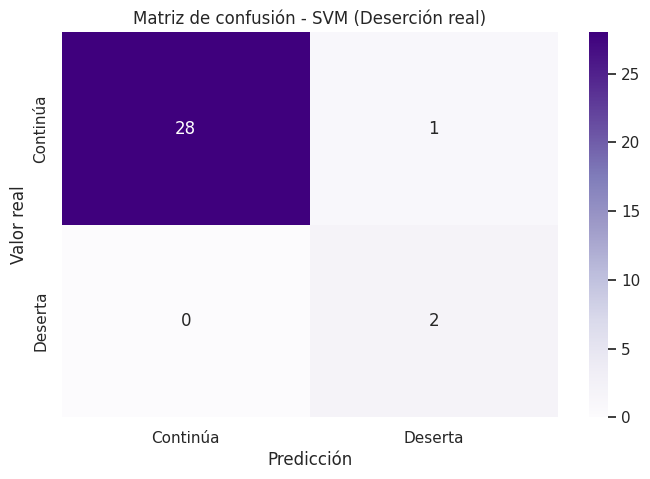

In [ ]:
# 9. MATRIZ DE CONFUSIÓN

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(
    cm, annot=True, fmt="d", cmap="Purples",
    xticklabels=["Continúa", "Deserta"],
    yticklabels=["Continúa", "Deserta"]
)
plt.title("Matriz de confusión - SVM (Deserción real)")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.show()

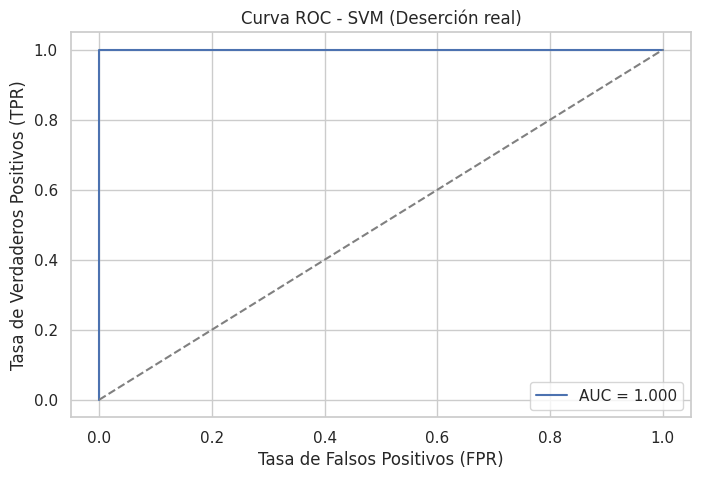

In [ ]:
# 10. CURVA ROC

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - SVM (Deserción real)")
plt.legend()
plt.show()


/tmp/ipython-input-301469600.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


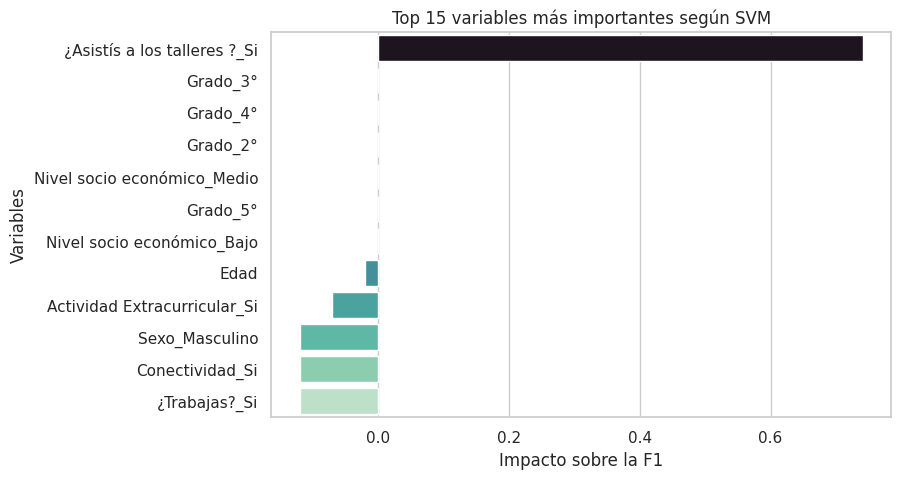


TOP 15 variables más importantes según SVM:
                        Variable  Importancia
8   ¿Asistís a los talleres ?_Si     0.741667
3                       Grado_3°     0.000000
4                       Grado_4°     0.000000
2                       Grado_2°     0.000000
11   Nivel socio económico_Medio     0.000000
5                       Grado_5°     0.000000
10    Nivel socio económico_Bajo     0.000000
0                           Edad    -0.020000
6   Actividad Extracurricular_Si    -0.070000
1                 Sexo_Masculino    -0.120000
7                Conectividad_Si    -0.120000
9                  ¿Trabajas?_Si    -0.120000


In [ ]:
# 11. IMPORTANCIA DE VARIABLES (Permutation Importance)

result = permutation_importance(
    modelo_svm,
    X_test_scaled,
    y_test,
    scoring="f1",
    n_repeats=20,
    random_state=42
)

importancias = pd.DataFrame({
    "Variable": X.columns,
    "Importancia": result.importances_mean
}).sort_values("Importancia", ascending=False)

sns.barplot(
    data=importancias.head(15),
    x="Importancia", y="Variable", palette="mako"
)
plt.title("Top 15 variables más importantes según SVM")
plt.xlabel("Impacto sobre la F1")
plt.ylabel("Variables")
plt.show()

print("\nTOP 15 variables más importantes según SVM:")
print(importancias.head(15))